In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.io import arff
from io import BytesIO

## Preprocess Datasets - Adolescent
### 1. Read data file

In [2]:
# Read file
data = arff.loadarff('Autism-Adolescent-Data.arff')
df_adol = pd.DataFrame(data[0])
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'0',b'0',b'0',b'1',b'1',b'1',b'1',b'1',b'1',b'0',...,b'm',b'Hispanic',b'yes',b'yes',b'Austria',b'no',6.0,b'12-16 years',b'Parent',b'NO'
1,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',...,b'm',b'Black',b'no',b'no',b'Austria',b'no',2.0,b'12-16 years',b'Relative',b'NO'
2,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',...,b'f',b'?',b'no',b'no',b'AmericanSamoa',b'no',2.0,b'12-16 years',b'?',b'NO'
3,b'0',b'1',b'1',b'1',b'1',b'1',b'0',b'1',b'1',b'0',...,b'f',b'White-European',b'no',b'no',b'United Kingdom',b'no',7.0,b'12-16 years',b'Self',b'YES'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'0',b'0',b'0',...,b'f',b'?',b'no',b'no',b'Albania',b'no',7.0,b'12-16 years',b'?',b'YES'


In [3]:
# Check data type of each feature in the dataset
df_adol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         104 non-null    object 
 1   A2_Score         104 non-null    object 
 2   A3_Score         104 non-null    object 
 3   A4_Score         104 non-null    object 
 4   A5_Score         104 non-null    object 
 5   A6_Score         104 non-null    object 
 6   A7_Score         104 non-null    object 
 7   A8_Score         104 non-null    object 
 8   A9_Score         104 non-null    object 
 9   A10_Score        104 non-null    object 
 10  age              104 non-null    float64
 11  gender           104 non-null    object 
 12  ethnicity        104 non-null    object 
 13  jundice          104 non-null    object 
 14  austim           104 non-null    object 
 15  contry_of_res    104 non-null    object 
 16  used_app_before  104 non-null    object 
 17  result          

### 2. Decode

In [4]:
for key in df_adol.columns.values.tolist():                # loop through all entries of the dataframe
    if (type(df_adol[key][0])==bytes):                     # find bytes object
        df_adol[key] = df_adol[key].str.decode('utf-8')   # Decode and replace
df_adol.head()                                             # check

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,0,0,0,1,1,1,1,1,1,0,...,m,Hispanic,yes,yes,Austria,no,6.0,12-16 years,Parent,NO
1,0,0,0,0,0,0,0,0,1,1,...,m,Black,no,no,Austria,no,2.0,12-16 years,Relative,NO
2,0,0,0,0,0,0,0,0,1,1,...,f,?,no,no,AmericanSamoa,no,2.0,12-16 years,?,NO
3,0,1,1,1,1,1,0,1,1,0,...,f,White-European,no,no,United Kingdom,no,7.0,12-16 years,Self,YES
4,1,1,1,1,1,1,1,0,0,0,...,f,?,no,no,Albania,no,7.0,12-16 years,?,YES


### 3. Visualization

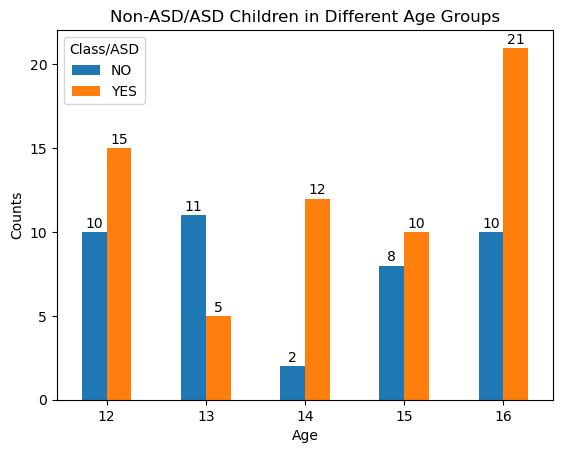

In [5]:
#display the number of Non-ASD/ASD children in different age groups
CrosstabResult = pd.crosstab(index = df_adol['age'],columns = df_adol['Class/ASD'], rownames=['Age'])
ax = CrosstabResult.plot.bar()

ax.set_title("Non-ASD/ASD Children in Different Age Groups")
ax.set_xlabel('Age')
ax.set_ylabel('Counts')
plt.xticks(ticks=range(len(np.unique(df_adol['age'].astype(int)))), labels=np.unique(df_adol['age'].astype(int)),rotation=0)
plt.yticks(ticks=[0,5,10,15,20], labels=[0,5,10,15,20])

for bar in ax.patches:
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2
    space = 1
    label = format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

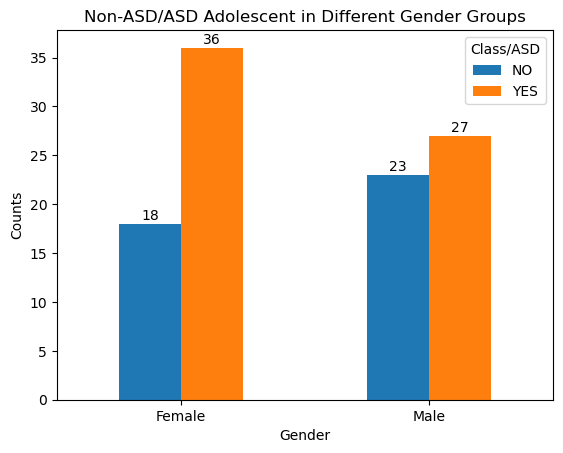

In [6]:
#display the number of Non-ASD/ASD children in different gender groups
CrosstabResult = pd.crosstab(index = df_adol['gender'],columns = df_adol['Class/ASD'], rownames=['Gender'])
ax = CrosstabResult.plot.bar()

ax.set_title("Non-ASD/ASD Adolescent in Different Gender Groups")
ax.set_xlabel('Gender')
ax.set_ylabel('Counts')
plt.xticks([0,1], ['Female', 'Male'], rotation=0)

for bar in ax.patches:
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2
    space = 1
    label = format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

### 4. Remove the entries, which we are not interessed

In [7]:
df_adol = df_adol.drop(['ethnicity', 'contry_of_res', 'age_desc'], axis=1)
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,0,0,0,1,1,1,1,1,1,0,15.0,m,yes,yes,no,6.0,Parent,NO
1,0,0,0,0,0,0,0,0,1,1,15.0,m,no,no,no,2.0,Relative,NO
2,0,0,0,0,0,0,0,0,1,1,12.0,f,no,no,no,2.0,?,NO
3,0,1,1,1,1,1,0,1,1,0,14.0,f,no,no,no,7.0,Self,YES
4,1,1,1,1,1,1,1,0,0,0,16.0,f,no,no,no,7.0,?,YES


### 5. One-Hot-Encoding

In [8]:
for key in df_adol.columns.values.tolist():
    print(key + " has value: ", df_adol[key].unique())

A1_Score has value:  ['0' '1']
A2_Score has value:  ['0' '1']
A3_Score has value:  ['0' '1']
A4_Score has value:  ['1' '0']
A5_Score has value:  ['1' '0']
A6_Score has value:  ['1' '0']
A7_Score has value:  ['1' '0']
A8_Score has value:  ['1' '0']
A9_Score has value:  ['1' '0']
A10_Score has value:  ['0' '1']
age has value:  [15. 12. 14. 16. 13.]
gender has value:  ['m' 'f']
jundice has value:  ['yes' 'no']
austim has value:  ['yes' 'no']
used_app_before has value:  ['no' 'yes']
result has value:  [ 6.  2.  7.  3.  4.  5.  9.  8. 10.  1.]
relation has value:  ['Parent' 'Relative' '?' 'Self' 'Health care professional' 'Others']
Class/ASD has value:  ['NO' 'YES']


In [9]:
df_adol['gender'] = df_adol['gender'].map({'m': 0, 'f': 1})
df_adol['jundice'] = df_adol['jundice'].map({'no': 0, 'yes': 1})
df_adol['austim'] = df_adol['austim'].map({'no': 0, 'yes': 1})
df_adol['used_app_before'] = df_adol['used_app_before'].map({'no': 0, 'yes': 1})
df_adol['relation'] = df_adol['relation'].map({'Parent': 0, 'Self': 1, 'Relative': 2, 'Health care professional': 3, 'Others':4, '?': 0})
df_adol['Class/ASD'] = df_adol['Class/ASD'].map({'NO': 0, 'YES': 1})
df_adol.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD
0,0,0,0,1,1,1,1,1,1,0,15.0,0,1,1,0,6.0,0,0
1,0,0,0,0,0,0,0,0,1,1,15.0,0,0,0,0,2.0,2,0
2,0,0,0,0,0,0,0,0,1,1,12.0,1,0,0,0,2.0,0,0
3,0,1,1,1,1,1,0,1,1,0,14.0,1,0,0,0,7.0,1,1
4,1,1,1,1,1,1,1,0,0,0,16.0,1,0,0,0,7.0,0,1


### 6. Handle missing value

In [10]:
df_adol[df_adol.isna().sum(axis=1) > 0] # Find whcih columns have missing value

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,used_app_before,result,relation,Class/ASD


In [11]:
# Some of the data are string not int, we will change it here
for key in df_adol.columns.values.tolist():        # loop though all entries           
    if (type(df_adol[key][0]) != int):             # Find non int data
        df_adol[key] = df_adol[key].astype(int)    # Change it to int

# Check dtype again
df_adol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   A1_Score         104 non-null    int32
 1   A2_Score         104 non-null    int32
 2   A3_Score         104 non-null    int32
 3   A4_Score         104 non-null    int32
 4   A5_Score         104 non-null    int32
 5   A6_Score         104 non-null    int32
 6   A7_Score         104 non-null    int32
 7   A8_Score         104 non-null    int32
 8   A9_Score         104 non-null    int32
 9   A10_Score        104 non-null    int32
 10  age              104 non-null    int32
 11  gender           104 non-null    int32
 12  jundice          104 non-null    int32
 13  austim           104 non-null    int32
 14  used_app_before  104 non-null    int32
 15  result           104 non-null    int32
 16  relation         104 non-null    int32
 17  Class/ASD        104 non-null    int32
dtypes: int32(1

### 7. Check the size and balance of processed dataset

In [12]:
print(
    "Number of negative results in the dataset: {}".format(len(df_adol[df_adol['Class/ASD'] == 0]))
)
print(
    "Number of positive results in the dataset: {}".format(len(df_adol[df_adol['Class/ASD'] == 1]))
)

Number of negative results in the dataset: 41
Number of positive results in the dataset: 63


## Build Randoom Forest Model

### 1. Split the data into training and testing set

In [13]:
# Split to data and labels
X = df_adol.copy().drop(['Class/ASD'], axis=1)
y = df_adol.copy()['Class/ASD']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Size of Training Set: ", len(X_train))
print("Size of Testing Set: ", len(X_test))


Size of Training Set:  83
Size of Testing Set:  21


### 2. Train the model

In [14]:
# Creat a random forest model
model = RandomForestClassifier(n_estimators=500)

In [15]:
# Train
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

## Evalute RF Model

### 1. Accuracy

In [16]:
# Test accuracy
y_pred = model.predict(X_test)
print("Accuracy on testing set:",sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy on testing set: 1.0


In [17]:
#Sanity Check
y_fake = np.random.choice([0,1], y_train.shape)   # Change the result to random numbers
print("Accuracy with fake results:",sklearn.metrics.accuracy_score(model.predict(X_train), y_fake))

Accuracy with fake results: 0.5301204819277109


### 2. F1-Score

In [18]:
f1 = sklearn.metrics.f1_score(y_test, y_pred)
print('F1 Score: ', f1)

F1 Score:  1.0


### 3. Confusion Matrix

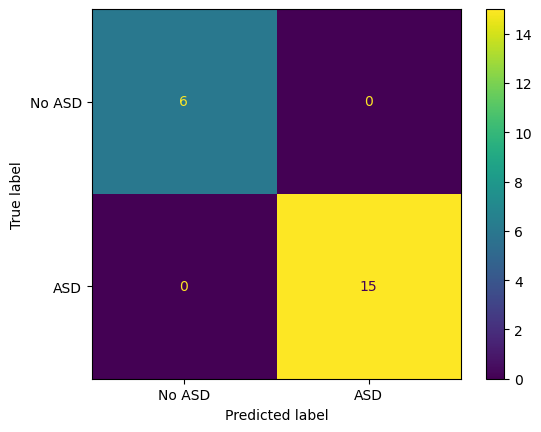

In [19]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No ASD', 'ASD'])
disp.plot()
plt.show()

### 4. Feature Ranking

In [20]:
importance = model.feature_importances_
index = np.argsort(model.feature_importances_).tolist()
index.reverse
std = np.std([tree.feature_importances_[index] for tree in model.estimators_], axis=0)
for idx in index:
    print(X_train.columns[idx], ": ", importance[idx])

used_app_before :  0.0051494012123575635
austim :  0.006247610993958744
jundice :  0.008404698737291575
gender :  0.01111450505259107
A1_Score :  0.01267571640362987
A2_Score :  0.015365983355624339
relation :  0.01612415400426266
age :  0.021448412517605733
A6_Score :  0.024405281319737973
A9_Score :  0.026294019928632232
A7_Score :  0.026780224478454198
A4_Score :  0.04037837042520996
A8_Score :  0.05580607174684841
A3_Score :  0.06491709203778528
A5_Score :  0.07881091388119732
A10_Score :  0.08940119551757826
result :  0.49667634838723485


Text(0, 0.5, 'Feature Name')

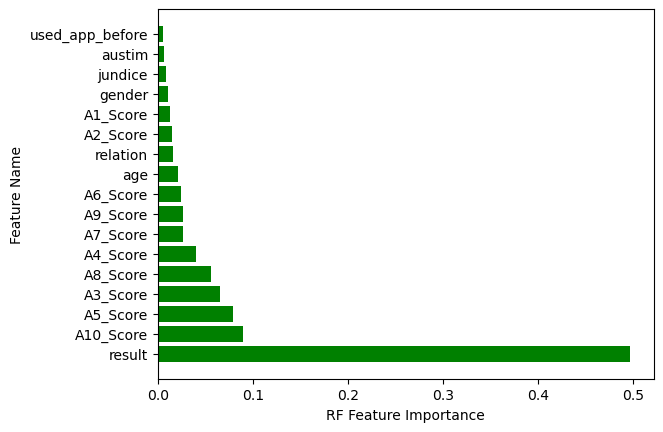

In [21]:
#plot bar chart of sorted features
plt.barh(X_train.columns[index], model.feature_importances_[index], color=['green'])
plt.gca().invert_yaxis()
plt.xlabel("RF Feature Importance")
plt.ylabel("Feature Name")


## Train Models with limited features

### 1. Use the 10 questions A1 to A10 to predict

Dropped features:  ['result', 'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
Used features ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
Accuracy: 0.8571428571428571


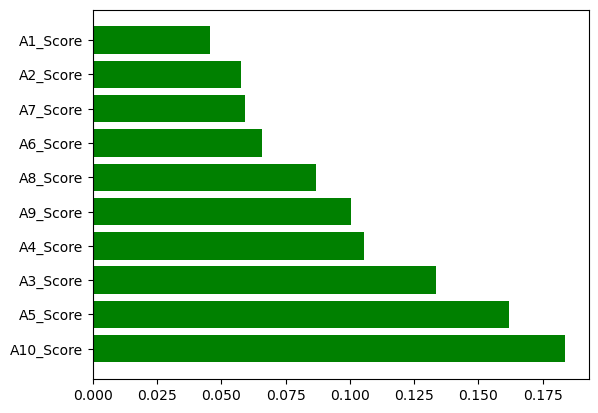

In [22]:
labels_to_drop = ['result', 'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
n_estimator = 500
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2)
model = RandomForestClassifier(n_estimators=n_estimator)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
importance = model.feature_importances_
index = np.argsort(importance).tolist()
fig, ax = plt.subplots()
ax = plt.barh(X_train.columns[index], importance[index], color="green")
#plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

### 2. Use only "result" to predict

In [23]:
labels_to_drop = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 
'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
n_estimator = 100
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.3)
model = RandomForestClassifier(n_estimators=n_estimator)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))

Dropped features:  ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'austim', 'used_app_before', 'age', 'gender', 'jundice', 'relation']
Used features ['result']
Accuracy: 1.0


### 3. Use features unrelated to AQ10

Dropped features:  ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
Used features ['age', 'gender', 'jundice', 'austim', 'used_app_before', 'relation']
Accuracy: 0.5238095238095238


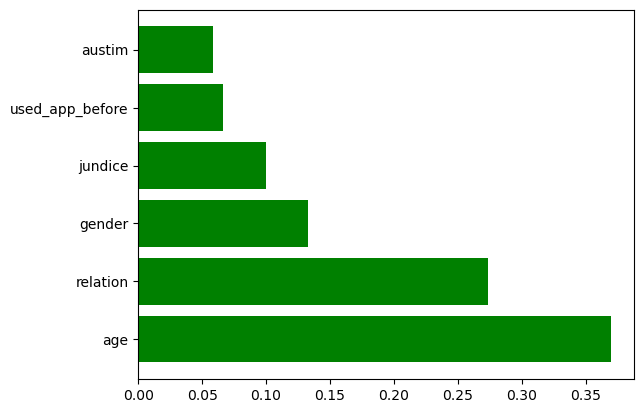

In [28]:
labels_to_drop = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
n_estimator = 500
X_drop = X.drop(labels=labels_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.2)
model = RandomForestClassifier(n_estimators=n_estimator)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Dropped features: ", labels_to_drop)
print("Used features", X_drop.columns.values.tolist())
print("Accuracy:",sklearn.metrics.accuracy_score(y_test, y_pred))
importance = model.feature_importances_
index = np.argsort(importance).tolist()
fig, ax = plt.subplots()
ax = plt.barh(X_train.columns[index], importance[index], color="green")
#plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

In [32]:
from scipy import stats
k = np.count_nonzero(y_test==y_pred)
n = len(y_pred)
print("Null hypothsis: The model trained on features unrelated to AQ10 is only guessing the result.")
print("Altenative hypothsis: The modle is not only guessing the result")
print("If the model is only guessing, for each result, it has 50\% chance to get the correct answer.")
print("The nuber of correct answer follows a binomial distribution B(21,0.5)")
p = stats.binomtest(k,n,1/2).pvalue
print("The model achieved an accuracy of {:.1f}%.".format(sklearn.metrics.accuracy_score(y_test, y_pred)*100))
print("P-Value of the result is {}.".format(p))
print("We can not reject the hypothesis that the model is only guessing.")

Null hypothsis: The model trained on features unrelated to AQ10 is only guessing the result.
Altenative hypothsis: The modle is not only guessing the result
If the model is only guessing, for each result, it has 50\% chance to get the correct answer.
The nuber of correct answer follows a binomial distribution B(21,0.5)
The model achieved an accuracy of 52.4%.
P-Value of the result is 1.0.
We can not reject the hypothesis that the model is only guessing.
